Looking at a dynamic programming solution for the case of ["next card bet"](https://github.com/WinVector/Examples/blob/main/puzzles/next_card_bet/Kelly_cant_fail.ipynb) with invisible stakes.

In [1]:
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
from plotnine import *
from card_count_fns import *

In [2]:
rng = np.random.default_rng(2024)

In [3]:
initial_stake = 100
n_cards_per_color = 26

In [4]:
ideal_return = theoretical_payout(n_cards_per_color, n_cards_per_color)

ideal_return

9.08132954942779

In [5]:
decks = [
    k_array_with_t_true(2 * n_cards_per_color, n_cards_per_color, rng=rng)
    for _ in range(10000)
]

In [6]:
payoffs_basic = [
    run_bets_int(
        deck,
        initial_stake=initial_stake,
        satiation_point=0,
        bet_strategy=basic_bet_strategy,
    )[0]
    for deck in decks
]

(np.min(payoffs_basic), np.mean(payoffs_basic), np.max(payoffs_basic))

(0.02, 9.082086000000002, 40.96)

In [7]:
assert np.min(payoffs_basic) > 0

In [8]:
np.std(payoffs_basic)

0.46441068958842874

In [9]:
plt_frame_basic = pd.DataFrame({"return": payoffs_basic, "strategy": "basic"})

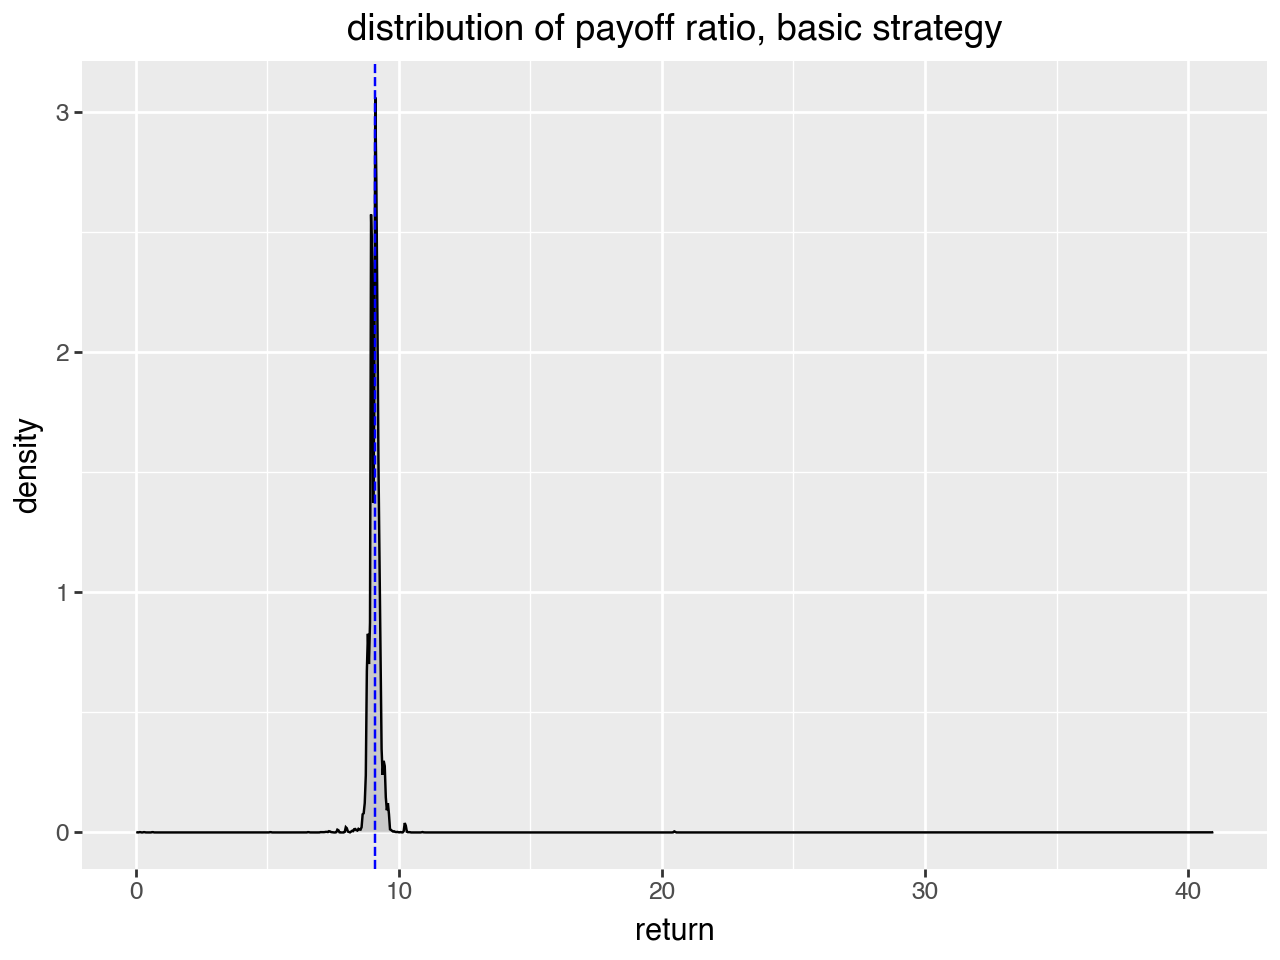

In [10]:
(
    ggplot(data=plt_frame_basic, mapping=aes(x="return"))
    + geom_density(fill="darkgray", alpha=0.5, trim=True)
    + geom_vline(xintercept=ideal_return, color="blue", linetype="--")
    + ggtitle("distribution of payoff ratio, basic strategy")
)

In [11]:
satiation_point = int(np.ceil(ideal_return * initial_stake))

_, min_payoff, mean_payoff = bet_amt_min_mean(
    initial_stake, n_cards_per_color, n_cards_per_color, satiation_point
)

min_empirical_return_rate = min_payoff / initial_stake

min_empirical_return_rate

8.08

In [12]:
mean_payoff / initial_stake

9.081329549427792

In [13]:
payoffs_dynprog = [
    run_bets_int(
        deck,
        initial_stake=initial_stake,
        satiation_point=satiation_point,
        bet_strategy=dynprog_bet_strategy,
    )[0]
    for deck in decks
]
assert np.min(payoffs_dynprog) >= min_empirical_return_rate

(np.min(payoffs_dynprog), np.mean(payoffs_dynprog), np.max(payoffs_dynprog))

(8.24, 9.08221, 81.92)

In [14]:
assert np.min(payoffs_dynprog) > 0

In [15]:
np.std(payoffs_dynprog)

1.0355260865376594

In [16]:
plt_frame_dynprog = pd.DataFrame({"return": payoffs_dynprog, "strategy": "dynprog"})

np.std(plt_frame_dynprog["return"])

1.035526086537651

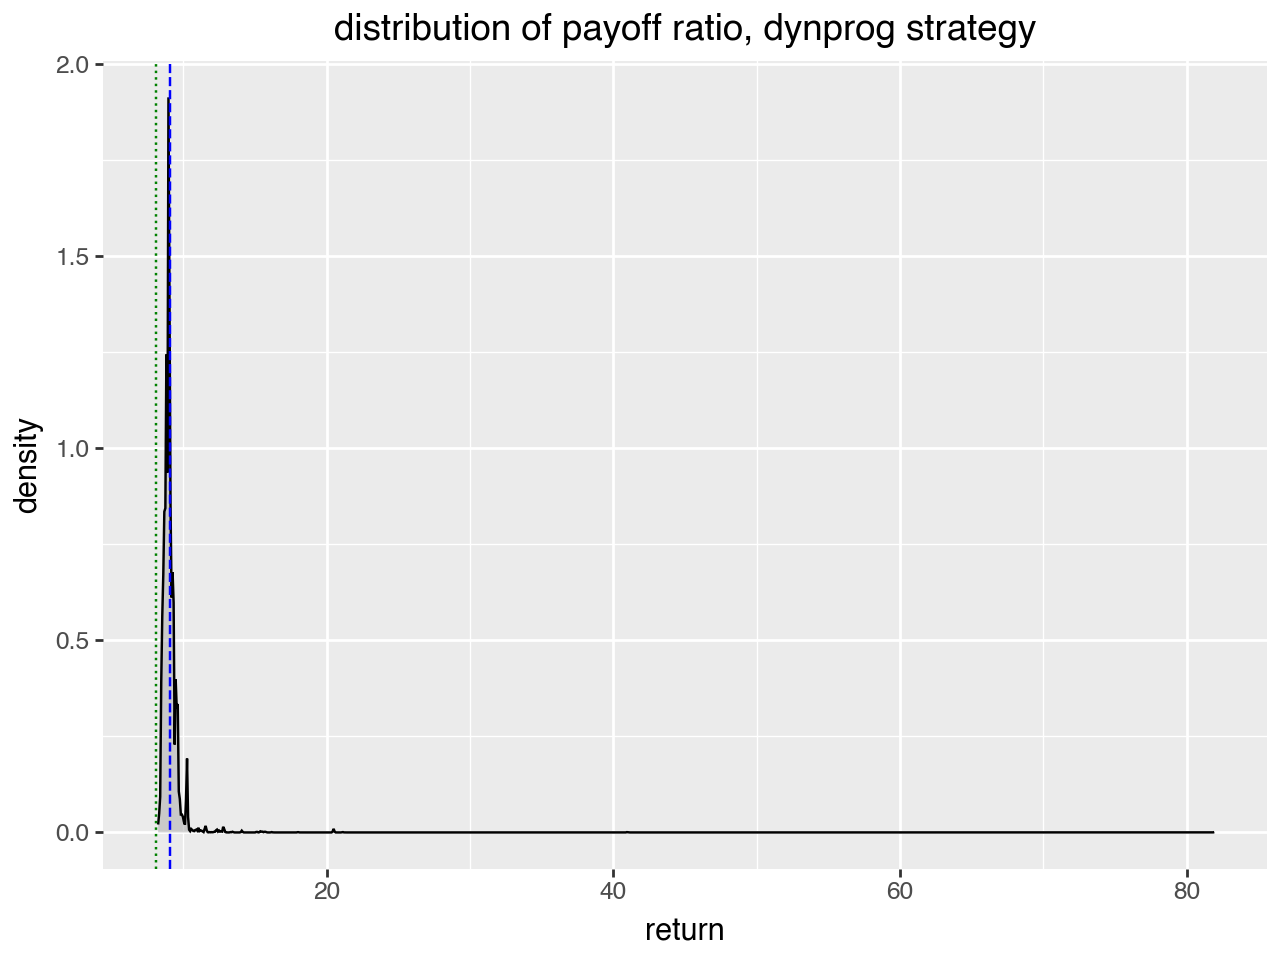

In [17]:
(
    ggplot(data=plt_frame_dynprog, mapping=aes(x="return"))
    + geom_density(fill="darkgray", alpha=0.5, trim=True)
    + geom_vline(xintercept=min_empirical_return_rate, color="green", linetype="dotted")
    + geom_vline(xintercept=ideal_return, color="blue", linetype="--")
    + ggtitle("distribution of payoff ratio, dynprog strategy")
)

In [18]:
plt_frame_both = pd.concat(
    [
        plt_frame_basic,
        plt_frame_dynprog,
    ],
    ignore_index=True,
)
plt_lower_bound = np.quantile(plt_frame_both["return"], 0.001)
plt_upper_bound = np.quantile(plt_frame_both["return"], 0.995)

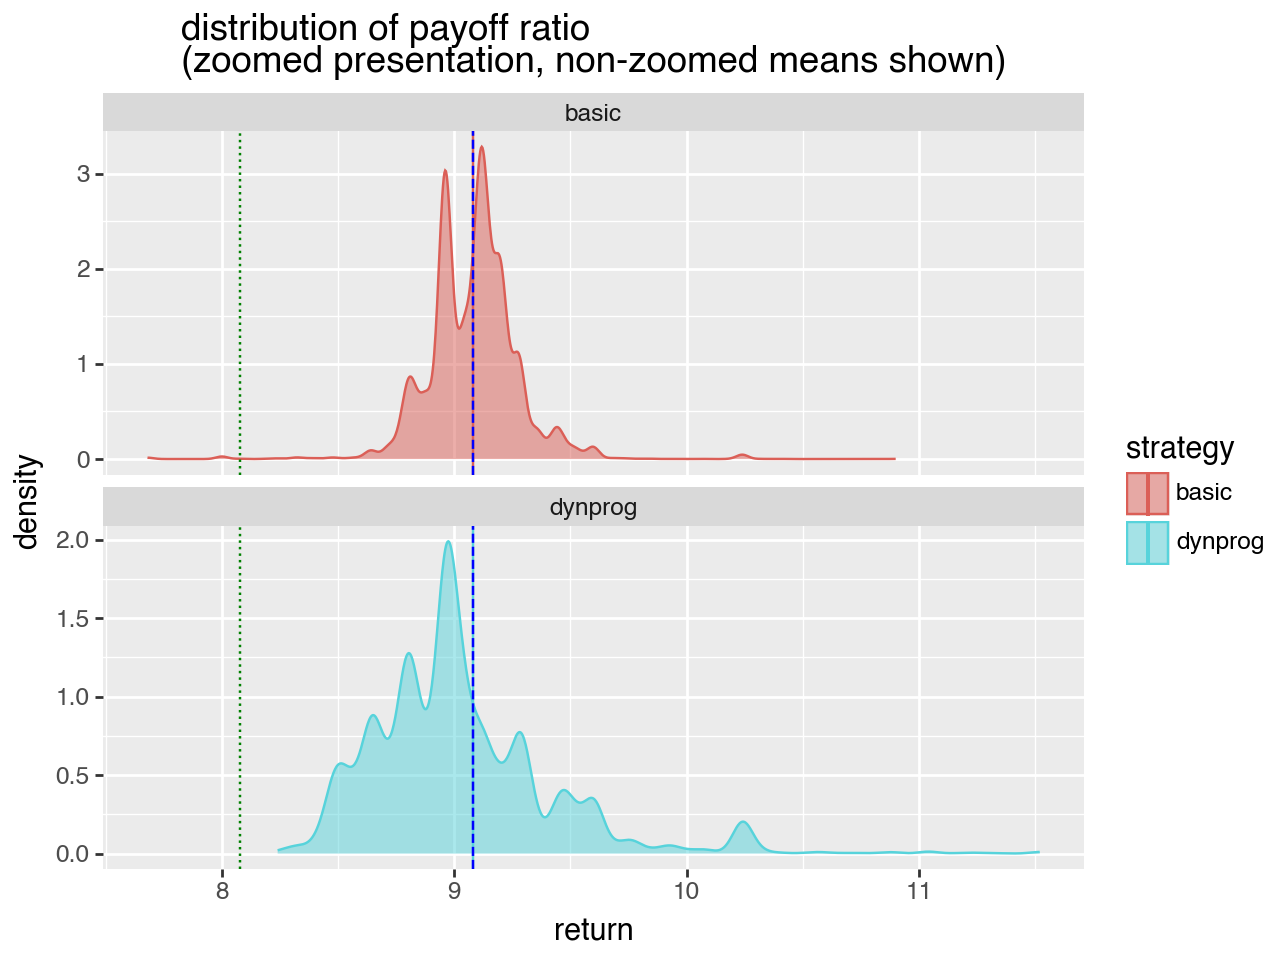

In [19]:
means_both = (
    plt_frame_both.groupby(["strategy"]).mean().reset_index(drop=False, inplace=False)
)
(
    ggplot(
        data=plt_frame_both.loc[
            (plt_frame_both["return"] >= plt_lower_bound)
            & (plt_frame_both["return"] <= plt_upper_bound),
            :,
        ],
        mapping=aes(x="return", color="strategy", fill="strategy"),
    )
    + geom_density(alpha=0.5, trim=True)
    + geom_vline(data=means_both, mapping=aes(xintercept="return", color="strategy"))
    + geom_vline(xintercept=min_empirical_return_rate, color="green", linetype="dotted")
    + geom_vline(xintercept=ideal_return, color="blue", linetype="--")
    + facet_wrap("strategy", ncol=1, scales="free_y")
    + ggtitle(
        "distribution of payoff ratio\n(zoomed presentation, non-zoomed means shown)"
    )
)

In [20]:
# overall stats
(plt_frame_both.groupby(["strategy"]).agg(["mean", "std"]))

return          
              mean       std
strategy                    
basic     9.082086  0.464434
dynprog   9.082210  1.035578

In [21]:
# zoomed stats
(
    plt_frame_both.loc[
        (plt_frame_both["return"] >= plt_lower_bound)
        & (plt_frame_both["return"] <= plt_upper_bound),
        :,
    ]
    .groupby(["strategy"])
    .agg(["mean", "std"])
)

return          
              mean       std
strategy                    
basic     9.081451  0.196737
dynprog   9.028417  0.399350

In [22]:
dynprog_bet_strategy(7, 20, 5, satiation_point)

2

In [23]:
basic_bet_strategy(7, 20, 5, satiation_point)

4

In [24]:
compare_frame = pd.DataFrame(
    {
        "basic": payoffs_basic,
        "dynprog": payoffs_dynprog,
    }
)

In [25]:
np.mean(compare_frame["dynprog"] - compare_frame["basic"])

0.0001240000000002322

In [26]:
np.min(compare_frame["basic"])

0.02

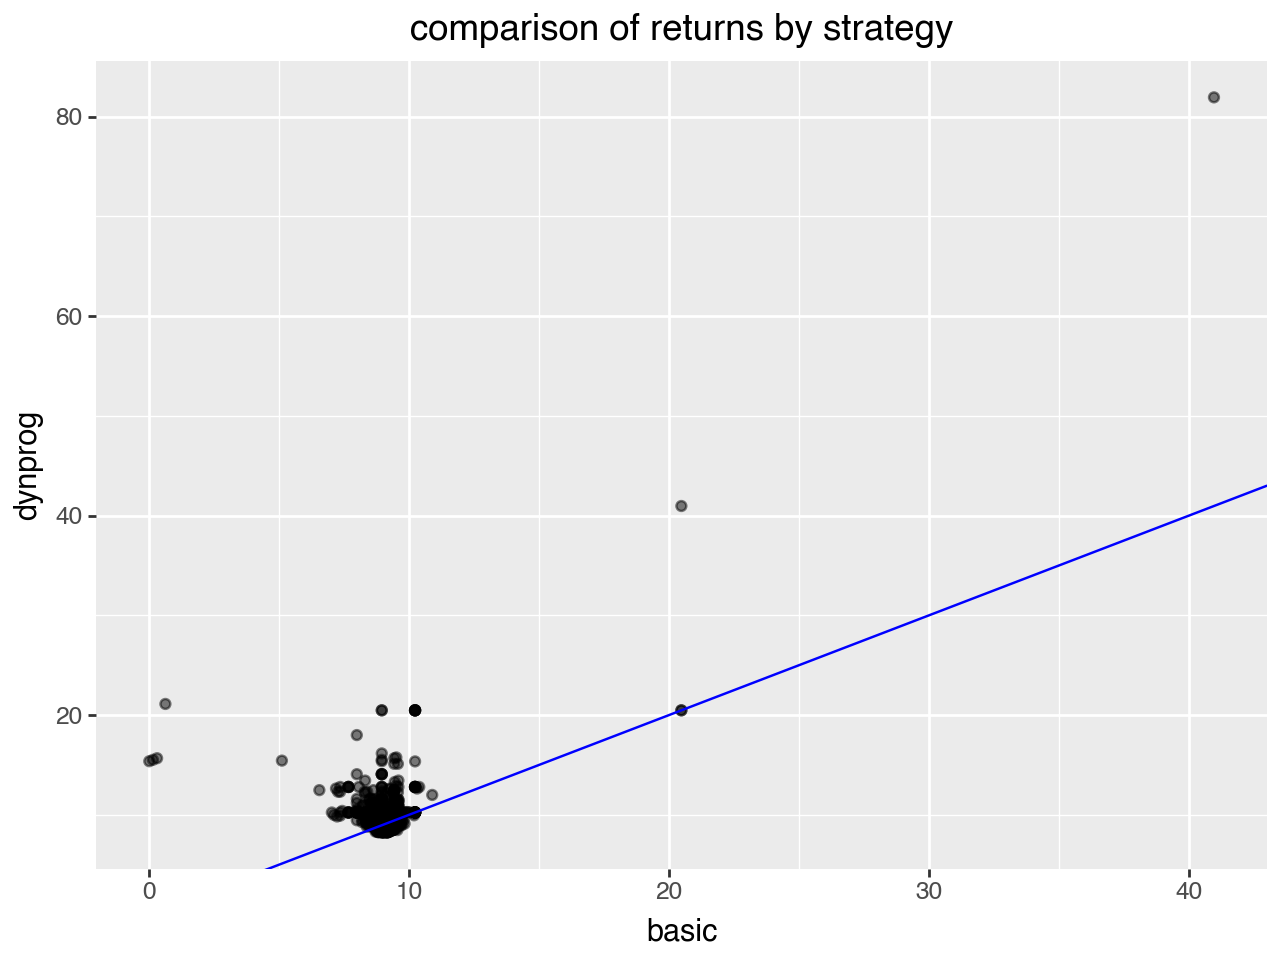

In [27]:
(
    ggplot(data=compare_frame, mapping=aes(x="basic", y="dynprog"))
    + geom_point(alpha=0.5)
    + geom_abline(intercept=0, slope=1, color="blue")
    + ggtitle("comparison of returns by strategy")
)

In [28]:
trajectories = [
    mk_traj_frame(
        i,
        bet_strategy=basic_bet_strategy,
        initial_stake=initial_stake,
        decks=decks,
        satiation_point=satiation_point,
    )
    for i in range(1000)
] + [
    mk_traj_frame(
        i,
        bet_strategy=dynprog_bet_strategy,
        initial_stake=initial_stake,
        decks=decks,
        satiation_point=satiation_point,
    )
    for i in range(1000)
]
trajectories = pd.concat(trajectories, ignore_index=True)

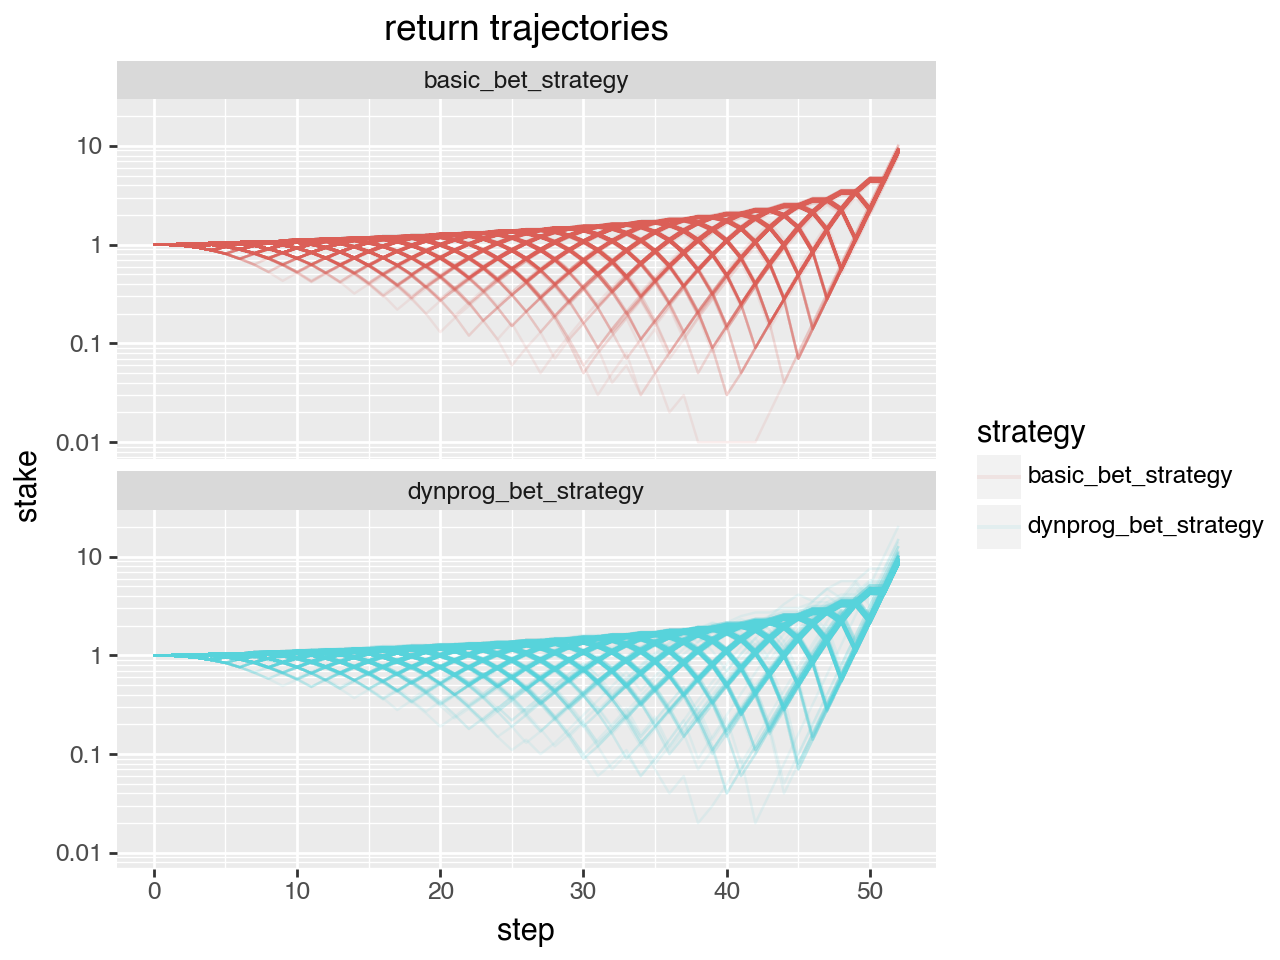

In [29]:
(
    ggplot(
        data=trajectories,
        mapping=aes(x="step", y="stake", color="strategy", group="trajectory"),
    )
    + geom_line(alpha=0.1)
    + scale_y_continuous(trans="log10")
    + facet_wrap("strategy", ncol=1)
    + ggtitle("return trajectories")
)